---
## 🔎 Automatic Pair Discovery (Yahoo Finance Top Cryptos)
Find the best pairing candidates with a chosen base symbol (e.g., BTC-USD or ETH-USD) by scanning top cryptocurrencies from Yahoo Finance and evaluating correlation, cointegration, stationarity, and half-life.

# Core pipeline (streamlined)

This notebook finds the best partners for BTC-USD and ETH-USD using a full statistical model.

Steps:
1) Parameters and universe: choose base symbols, fetch top crypto tickers (ex-stablecoins)
2) Data: download daily Close prices for base + candidates
3) Metrics: compute full model per pair
   - OLS alpha/beta, R²/adj-R², F-statistics
   - Residual diagnostics: Jarque–Bera, skew, kurtosis, Durbin–Watson
   - Engle–Granger cointegration (t, p), ADF on residuals
   - OU half-life; z-score stats (current, ±1/±2 exceedance)
   - Composite score and rating
4) Results: rank and export per base, combined leaderboard
5) Visuals: normalized prices and residual z-score for top pair per base

In [135]:
# === Scan Parameters ===
base_symbol = "ETH-USD"   # default base; change to "BTC-USD" if needed
top_n = 30                 # how many top cryptos to scan
min_history_days = 365*2   # require at least ~2 years of overlap
exclude_stables = {"USDT-USD","USDC-USD","BUSD-USD","DAI-USD","TUSD-USD","FDUSD-USD","PYUSD-USD","EURT-USD"}

print(f"Base: {base_symbol} | Top N: {top_n} | Min days: {min_history_days}")

Base: ETH-USD | Top N: 30 | Min days: 730


In [136]:
# === Helper: Fetch top crypto tickers (robust: headers + retries + cache + Coinbase fallback) ===
import pandas as pd
import numpy as np
import requests
import os, json, time, re
from io import StringIO

YA_CRYPTO_URL = "https://finance.yahoo.com/cryptocurrencies/?count=250&offset=0"
TICKER_CACHE = "tickers_cache.json"
TICKER_RETRIES = 3
TICKER_SLEEP = 1.5
HTTP_HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}
_SYM_PAT = re.compile(r"[A-Z0-9\-]{2,}-USD")

fallback_tickers = [
    "BNB-USD","SOL-USD","XRP-USD","ADA-USD","DOGE-USD","TRX-USD","AVAX-USD",
    "LINK-USD","MATIC-USD","DOT-USD","LTC-USD","NEAR-USD","BCH-USD","ATOM-USD",
    "UNI7083-USD","ETC-USD","XLM-USD","XMR-USD","APT-USD","OP-USD","ALGO-USD",
    "FIL-USD","HBAR-USD","ICP-USD","SUI-USD","INJ-USD","IMX-USD","ARB-USD",
    "AAVE-USD","EOS-USD","MKR-USD","FTM-USD","EGLD-USD","RUNE-USD","THETA-USD"
]

def _normalize_syms(lst):
    out = []
    for v in lst:
        s = str(v)
        m = _SYM_PAT.search(s)
        if m:
            out.append(m.group(0))
    return list(dict.fromkeys([x for x in out if x.endswith('-USD')]))

def _load_ticker_cache():
    if os.path.exists(TICKER_CACHE):
        try:
            with open(TICKER_CACHE, 'r', encoding='utf-8') as f:
                data = json.load(f)
            if isinstance(data, list) and data:
                # Clean cached content to strip prefixes like 'B BTC-USD'
                cleaned = _normalize_syms(data)
                if cleaned and cleaned != data:
                    _save_ticker_cache(cleaned)
                return cleaned if cleaned else None
        except Exception:
            return None
    return None

def _save_ticker_cache(lst):
    try:
        with open(TICKER_CACHE, 'w', encoding='utf-8') as f:
            json.dump(lst, f)
    except Exception:
        pass

def _fetch_yahoo_symbols():
    # Try a few times with headers to reduce 429
    last_exc = None
    for _ in range(TICKER_RETRIES):
        try:
            r = requests.get(YA_CRYPTO_URL, headers=HTTP_HEADERS, timeout=20)
            if r.status_code == 200:
                tables = pd.read_html(StringIO(r.text))
                raw_syms = []
                for t in tables:
                    for col in t.columns:
                        vals = t[col].astype(str).tolist()
                        raw_syms.extend(vals)
                return _normalize_syms(raw_syms)
            elif r.status_code == 429:
                time.sleep(TICKER_SLEEP)
            else:
                last_exc = Exception(f"HTTP {r.status_code}")
                break
        except Exception as e:
            last_exc = e
            time.sleep(TICKER_SLEEP)
    if last_exc:
        print(f"[WARN] Yahoo symbol fetch failed: {last_exc}")
    return []

def _fetch_coinbase_symbols():
    # Coinbase products endpoint provides product ids like BTC-USD
    try:
        r = requests.get("https://api.exchange.coinbase.com/products", timeout=20)
        if r.status_code != 200:
            print(f"[WARN] Coinbase products HTTP {r.status_code}")
            return []
        data = r.json()
        syms = [d.get('id') for d in data if isinstance(d, dict) and str(d.get('id','')).endswith('-USD')]
        # remove obvious stablecoins if present
        stables = {"USDT-USD","USDC-USD","BUSD-USD","DAI-USD","TUSD-USD","FDUSD-USD","PYUSD-USD","EURT-USD"}
        syms = [s for s in syms if s not in stables]
        return list(dict.fromkeys(syms))
    except Exception as e:
        print(f"[WARN] Coinbase symbol fetch failed: {e}")
        return []

def get_top_crypto_tickers(top_n=30):
    # 0) Try cache to avoid repeated scraping
    cached = _load_ticker_cache()
    if cached:
        return cached[:top_n]

    # 1) Try Yahoo page with headers & retries
    syms = _fetch_yahoo_symbols()
    if not syms:
        print("[WARN] Yahoo Finance scrape failed; trying Coinbase products list.")
        # 2) Try Coinbase products as a fallback list
        syms = _fetch_coinbase_symbols()

    # 3) Final fallback to built-in list
    if not syms:
        print("[WARN] Using built-in fallback ticker list.")
        syms = fallback_tickers
    # Dedup, normalize and cache
    syms = _normalize_syms(syms)
    if syms:
        _save_ticker_cache(syms)
    return syms[:top_n]

candidates_all = get_top_crypto_tickers(top_n)
# Exclude base and stablecoins
exclude_stables = {"USDT-USD","USDC-USD","BUSD-USD","DAI-USD","TUSD-USD","FDUSD-USD","PYUSD-USD","EURT-USD"}
candidates = [t for t in candidates_all if t != base_symbol and t not in exclude_stables]
print(f"Candidates ({len(candidates)}): {candidates[:10]}{'...' if len(candidates)>10 else ''}")

Candidates (22): ['BTC-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'STETH-USD', 'DOGE-USD', 'TRX-USD', 'WTRX-USD', 'ADA-USD', 'WSTETH-USD']...


In [137]:
# existing candidate list already built: `candidates`
import re

# Wrapper/derivative hygiene
UNDERLYING_MAP = {
    'WETH': 'ETH', 'WBTC': 'BTC', 'WSTETH': 'ETH', 'STETH': 'ETH',
    'WTRX': 'TRX', 'WBCH': 'BCH', 'WBNB': 'BNB', 'WBETH': 'ETH',
    'WAVAX': 'AVAX', 'WSOL': 'SOL', 'WADA': 'ADA', 'WXTZ': 'XTZ',
}
WRAPPER_BASES = set(UNDERLYING_MAP.keys())


def base_token(sym: str) -> str:
    return sym.split('-')[0].upper().strip()


def root_token(sym: str) -> str:
    b = base_token(sym)
    return UNDERLYING_MAP.get(b, b)


if EXCLUDE_WRAPPERS:
    candidates = [s for s in candidates if base_token(s) not in WRAPPER_BASES]

# Always ensure stables are excluded
candidates = [s for s in candidates if base_token(s) not in exclude_stables]

if DEDUP_BY_ROOT:
    seen = set()
    deduped = []
    for s in candidates:
        r = root_token(s)
        if r not in seen:
            seen.add(r)
            deduped.append(s)
    candidates = deduped

print(f"Candidates after hygiene (EXCLUDE_WRAPPERS={EXCLUDE_WRAPPERS}, DEDUP_BY_ROOT={DEDUP_BY_ROOT}): {len(candidates)} -> {candidates[:10]}...")

Candidates after hygiene (EXCLUDE_WRAPPERS=True, DEDUP_BY_ROOT=True): 16 -> ['BTC-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'DOGE-USD', 'TRX-USD', 'ADA-USD', 'HYPE32196-USD', 'LINK-USD', 'BCH-USD']...


---
## 🚀 Batch Scan for BTC and ETH
Run a full scan to find the best pairing candidates for both BTC-USD and ETH-USD using the same rigorous metrics and scoring.

In [138]:
# === Function: compute metrics for BASE against all other tickers in a prices frame ===
from typing import List, Dict
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import pearsonr, jarque_bera, skew, kurtosis


def _halflife_ou(resid: pd.Series) -> float:
    r = resid.dropna()
    if len(r) < 5:
        return np.nan
    lag = r.shift(1)
    delta = r - lag
    df = pd.concat([delta.rename("delta"), lag.rename("lag")], axis=1).dropna()
    if df.shape[0] < 5:
        return np.nan
    X = sm.add_constant(df["lag"])  # delta = a + b*lag
    model = sm.OLS(df["delta"], X).fit()
    b = model.params.get("lag", np.nan)
    # OU half-life approximation; if b >= 0, mean reversion not detected
    if not np.isfinite(b) or b >= 0:
        return np.inf
    hl = -np.log(2.0) / b
    return float(hl) if np.isfinite(hl) and hl > 0 else np.inf


def compute_pair_metrics(BASE: str, prices_frame: pd.DataFrame, min_days: int = 730) -> pd.DataFrame:
    """Compute full metrics for BASE vs all other assets using the full BTC/ETH model set.

    Returns columns:
      - ticker, n_obs
      - corr, cov
      - alpha, beta, r2, adj_r2, f_stat, f_pvalue
      - jb_stat, jb_pvalue, skew, kurt, dw_stat
      - coint_t, coint_p
      - adf_stat, adf_p
      - half_life
      - z_mean, z_std, z_current, z_gt1, z_gt2, z_lt_1, z_lt_2
      - score, rating
    """
    cols = [c for c in prices_frame.columns if c != BASE]
    results: List[Dict] = []

    base = prices_frame[BASE].dropna()

    for t in cols:
        y = prices_frame[t].dropna()
        pair = pd.concat([base.rename(BASE), y.rename(t)], axis=1).dropna()
        if pair.shape[0] < min_days:
            continue

        # Regression y ~ const + x
        X = sm.add_constant(pair[BASE])
        mdl = sm.OLS(pair[t], X).fit()
        alpha = float(mdl.params.get("const", np.nan))
        beta = float(mdl.params.get(BASE, np.nan))
        r2 = float(mdl.rsquared)
        adj_r2 = float(mdl.rsquared_adj)
        f_stat = float(getattr(mdl, "fvalue", np.nan))
        f_pvalue = float(getattr(mdl, "f_pvalue", np.nan))

        resid = mdl.resid
        # Residual diagnostics
        jb_stat, jb_p = jarque_bera(resid)
        dw = durbin_watson(resid)
        sk = float(skew(resid, bias=False))
        ku = float(kurtosis(resid, fisher=True, bias=False))

        # Cointegration and ADF on residuals
        try:
            c_t, c_p, _crit = coint(pair[BASE], pair[t])
        except Exception:
            c_t, c_p = np.nan, np.nan
        try:
            adf_res = adfuller(resid.dropna(), autolag="AIC")
            adf_stat = float(adf_res[0])
            adf_p = float(adf_res[1])
        except Exception:
            adf_stat, adf_p = np.nan, np.nan

        # Correlation & covariance
        try:
            corr, _ = pearsonr(pair[BASE], pair[t])
        except Exception:
            corr = float(pair[BASE].corr(pair[t]))
        cov = float(pair[BASE].cov(pair[t]))

        # Half-life
        hl = _halflife_ou(resid)

        # Z-score series
        z = (resid - resid.mean()) / resid.std(ddof=0)
        z_mean = float(z.mean())
        z_std = float(z.std(ddof=0))
        z_current = float(z.iloc[-1])
        z_gt1 = float((z > 1).mean())
        z_gt2 = float((z > 2).mean())
        z_lt_1 = float((z < -1).mean())
        z_lt_2 = float((z < -2).mean())

        # Composite score (0-100)
        corr_score = np.clip((corr - 0.5) / 0.5, 0, 1) * 25  # prefer corr >= 0.5
        coint_score = np.clip((0.3 - (c_p if np.isfinite(c_p) else 1)) / 0.3, 0, 1) * 30  # prefer p <= 0.3
        adf_score = np.clip((0.1 - (adf_p if np.isfinite(adf_p) else 1)) / 0.1, 0, 1) * 25  # prefer p <= 0.1
        hl_score = np.clip((120 - (hl if np.isfinite(hl) else 1e6)) / 120, 0, 1) * 20  # prefer hl <= 120 days
        score = int(round(corr_score + coint_score + adf_score + hl_score))

        rating = (
            "Good" if (corr >= 0.8 and (c_p if np.isfinite(c_p) else 1) < 0.05 and (adf_p if np.isfinite(adf_p) else 1) < 0.05 and hl < 60)
            else "Fair" if (corr >= 0.7 and (c_p if np.isfinite(c_p) else 1) < 0.1 and (adf_p if np.isfinite(adf_p) else 1) < 0.1 and hl < 120)
            else "Weak"
        )

        results.append({
            "ticker": t,
            "n_obs": int(pair.shape[0]),
            "corr": float(corr),
            "cov": float(cov),
            "alpha": alpha,
            "beta": beta,
            "r2": r2,
            "adj_r2": adj_r2,
            "f_stat": f_stat,
            "f_pvalue": f_pvalue,
            "jb_stat": float(jb_stat),
            "jb_pvalue": float(jb_p),
            "skew": sk,
            "kurt": ku,
            "dw_stat": float(dw),
            "coint_t": float(c_t) if np.isfinite(c_t) else np.nan,
            "coint_p": float(c_p) if np.isfinite(c_p) else np.nan,
            "adf_stat": adf_stat,
            "adf_p": adf_p,
            "half_life": float(hl) if np.isfinite(hl) else np.inf,
            "z_mean": z_mean,
            "z_std": z_std,
            "z_current": z_current,
            "z_gt1": z_gt1,
            "z_gt2": z_gt2,
            "z_lt_1": z_lt_1,
            "z_lt_2": z_lt_2,
            "score": score,
            "rating": rating,
        })

    df_out = pd.DataFrame(results).sort_values(["score", "corr"], ascending=[False, False])
    return df_out.reset_index(drop=True)

In [139]:
# Optional date overrides
import pandas as pd
if CUSTOM_START_DATE is not None or CUSTOM_END_DATE is not None:
    if CUSTOM_START_DATE is not None:
        start_date = pd.to_datetime(CUSTOM_START_DATE).date()
    if CUSTOM_END_DATE is not None:
        end_date = pd.to_datetime(CUSTOM_END_DATE).date()
    print(f"Date range overridden -> {start_date} to {end_date}")

In [140]:
# === Date range parameters (always define before downloads) ===
import pandas as pd
_today = pd.Timestamp.utcnow().normalize().date()
_min_days = globals().get('min_history_days', 730)
start_date = (pd.Timestamp(_today) - pd.Timedelta(days=int(_min_days) + 30)).date()  # buffer 30 days
end_date = _today
print(f"Date range: {start_date} -> {end_date} (min_history_days={_min_days})")


# === Robust download helpers (rate limit + retries + caching + Coinbase fallback) ===
import os, time, json, math, requests
import numpy as np
import pandas as pd
import yfinance as yf
from typing import List, Dict, Optional


DATA_CACHE_DIR = 'data_cache'
os.makedirs(DATA_CACHE_DIR, exist_ok=True)


# Throttle & retry settings
REQUEST_SLEEP_SEC = 1.5   # delay between single requests to avoid 429
RETRIES = 3               # retry attempts per ticker
BACKOFF = 1.6             # exponential backoff multiplier
DATA_SOURCE_PRIORITY = ['yfinance', 'coinbase']  # order to try for singles


def _cache_path(ticker: str) -> str:
    return os.path.join(DATA_CACHE_DIR, f"{ticker.replace('/', '_')}_1d.csv")


def _save_cache_series(ticker: str, s: pd.Series):
    if s is None or s.empty:
        return
    df = s.rename('Close').to_frame()
    df.index.name = 'Date'
    df.to_csv(_cache_path(ticker))


def _load_cache_series(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Series]:
    fp = _cache_path(ticker)
    if not os.path.exists(fp):
        return None
    try:
        df = pd.read_csv(fp, parse_dates=['Date']).set_index('Date')
        df = df[(df.index.date >= start) & (df.index.date <= end)]
        if not df.empty:
            return df['Close']
    except Exception:
        return None
    return None


def _fetch_yf_single(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Series]:
    # Single-ticker download via yfinance with retries/backoff
    delay = REQUEST_SLEEP_SEC
    last_exc = None
    for i in range(RETRIES):
        try:
            df = yf.download(ticker, start=start, end=end, interval='1d', progress=False, auto_adjust=False)
            if isinstance(df, pd.DataFrame) and 'Close' in df.columns and not df['Close'].dropna().empty:
                s = df['Close'].rename(ticker).dropna()
                return s
        except Exception as e:
            last_exc = e
        time.sleep(delay)
        delay *= BACKOFF
    # final failure
    if last_exc:
        print(f"  [yf fail] {ticker}: {last_exc}")
    return None


def _fetch_coinbase_daily(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Series]:
    # Coinbase uses product ids like 'BTC-USD' matching our format
    # API: GET /products/<product-id>/candles?granularity=86400&start=&end=
    try:
        start_iso = pd.Timestamp(start).isoformat() + 'Z'
        end_iso = (pd.Timestamp(end) + pd.Timedelta(days=1)).isoformat() + 'Z'  # inclusive end
        url = f"https://api.exchange.coinbase.com/products/{ticker}/candles"
        params = {'granularity': 86400, 'start': start_iso, 'end': end_iso}
        r = requests.get(url, params=params, timeout=20)
        if r.status_code != 200:
            print(f"  [coinbase {ticker}] HTTP {r.status_code}")
            return None
        # Response is list of [time, low, high, open, close, volume] in seconds since epoch, most-recent first
        data = r.json()
        if not data:
            return None
        rows = sorted(data, key=lambda x: x[0])
        idx = pd.to_datetime([pd.Timestamp(int(ts), unit='s').date() for ts, *_ in rows])
        close = [row[4] for row in rows]
        s = pd.Series(close, index=idx, name=ticker)
        s.index.name = 'Date'
        s = s[(s.index.date >= start) & (s.index.date <= end)]
        return s
    except Exception as e:
        print(f"  [coinbase fail] {ticker}: {e}")
        return None


def fetch_single_series(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Series]:
    # Try cache first
    s = _load_cache_series(ticker, start, end)
    if s is not None and not s.empty:
        return s.rename(ticker)


    # Try sources in priority order
    for src in DATA_SOURCE_PRIORITY:
        if src == 'yfinance':
            s = _fetch_yf_single(ticker, start, end)
        elif src == 'coinbase':
            s = _fetch_coinbase_daily(ticker, start, end)
        else:
            s = None
        if s is not None and not s.empty:
            _save_cache_series(ticker, s)
            return s.rename(ticker)
        time.sleep(REQUEST_SLEEP_SEC)
    return None


def download_union_prices(union_tickers: List[str], start: pd.Timestamp, end: pd.Timestamp, chunk_size: int = 16) -> pd.DataFrame:
    wide = pd.DataFrame()


    # 1) Try chunked yfinance batch downloads to minimize request count
    try:
        for i in range(0, len(union_tickers), chunk_size):
            chunk = union_tickers[i:i+chunk_size]
            raw = yf.download(chunk, start=start, end=end, interval='1d', group_by='ticker', progress=False, auto_adjust=False, threads=True)
            # If DataFrame is multi-indexed by ticker/field
            for t in chunk:
                try:
                    s = raw[t]['Close'].rename(t).dropna() if isinstance(raw.columns, pd.MultiIndex) else raw['Close'].rename(t).dropna()
                    if s is not None and not s.empty:
                        wide = pd.concat([wide, s], axis=1)
                except Exception:
                    pass
            time.sleep(REQUEST_SLEEP_SEC)
    except Exception as e:
        print(f"[WARN] Chunked batch download failed: {e}")


    # 2) Fill missing tickers with throttled single fetch + cache + coinbase fallback
    have = set(wide.columns)
    missing = [t for t in union_tickers if t not in have]
    if missing:
        print(f"Filling missing singles: {len(missing)}")
        for t in missing:
            s = fetch_single_series(t, start, end)
            if s is not None and not s.empty:
                wide = pd.concat([wide, s.rename(t)], axis=1)
            time.sleep(REQUEST_SLEEP_SEC)
    return wide.sort_index()


# === Download union prices for BTC & ETH scans (robust) ===
base_list = ["BTC-USD", "ETH-USD"]
union_tickers = sorted(set(candidates) | set(base_list))
print(f"Union tickers ({len(union_tickers)}): first 10 -> {union_tickers[:10]}")


prices_union = download_union_prices(union_tickers, pd.Timestamp(start_date), pd.Timestamp(end_date), chunk_size=16)


valid_cols = [c for c in prices_union.columns if prices_union[c].dropna().shape[0] >= min_history_days]
prices_union = prices_union[valid_cols]
print(f"Union price frame: {prices_union.shape}")

Date range: 2023-10-02 -> 2025-10-31 (min_history_days=730)
Union tickers (17): first 10 -> ['ADA-USD', 'AETHWETH-USD', 'BCH-USD', 'BNB-USD', 'BTC-USD', 'DOGE-USD', 'ETH-USD', 'HYPE32196-USD', 'LEO-USD', 'LINK-USD']
Union price frame: (760, 12)
Union price frame: (760, 12)


In [141]:
# Apply strict filters/dedup to scan results and reselect best pair
import json
import os

if 'combo' in globals():
    df = combo.copy()

    # Limit to current base, if available
    try:
        current_base = base_symbol
        df = df[df['base'] == current_base]
    except Exception:
        pass

    # Hygiene helpers (reuse definitions if available)
    try:
        UNDERLYING_MAP
    except NameError:
        UNDERLYING_MAP = {
            'WETH': 'ETH', 'WBTC': 'BTC', 'WSTETH': 'ETH', 'STETH': 'ETH',
            'WTRX': 'TRX', 'WBCH': 'BCH', 'WBNB': 'BNB', 'WBETH': 'ETH',
            'WAVAX': 'AVAX', 'WSOL': 'SOL', 'WADA': 'ADA', 'WXTZ': 'XTZ',
        }
    WRAPPER_BASES = set(UNDERLYING_MAP.keys())

    def base_token(sym: str) -> str:
        return str(sym).split('-')[0].upper().strip()

    def root_token(sym: str) -> str:
        b = base_token(sym)
        return UNDERLYING_MAP.get(b, b)

    # Exclude wrappers and stables in results if requested
    if EXCLUDE_WRAPPERS:
        df = df[~df['ticker'].map(lambda s: base_token(s) in WRAPPER_BASES)]
    if 'exclude_stables' in globals():
        df = df[~df['ticker'].map(lambda s: base_token(s) in exclude_stables)]

    # Strict metric filters
    def apply_filters(d, corr_min, coint_max, adf_max, hl_max):
        return d[(d['corr'] >= corr_min) & (d['coint_p'] <= coint_max) & (d['adf_p'] <= adf_max) & (d['half_life'] <= hl_max)]

    if STRICT_FILTERS:
        df_f = apply_filters(df, CORR_MIN, COINT_P_MAX, ADF_P_MAX, HL_MAX_DAYS)
        if not len(df_f):
            # soften if nothing passes
            df_f = apply_filters(df, max(0.55, CORR_MIN - 0.15), min(0.15, COINT_P_MAX + 0.10), min(0.15, ADF_P_MAX + 0.10), min(240, HL_MAX_DAYS * 2))
            if len(df_f):
                print("Strict filters yielded 0; using softened thresholds for selection.")
        df = df_f

    # Deduplicate by root (keep highest score per root)
    if DEDUP_BY_ROOT and len(df):
        df['_root'] = df['ticker'].map(root_token)
        df = df.sort_values('score', ascending=False).drop_duplicates(subset=['_root'], keep='first')
        df = df.drop(columns=['_root'])

    # Select best row
    if len(df):
        best_row = df.sort_values('score', ascending=False).iloc[0]
        SELECTED_BASE = best_row['base']
        SELECTED_CAND = best_row['ticker']
        SELECTED_ROW = best_row
        # Persist selection so later cells and fresh sessions stay consistent
        with open('selected_pair.json', 'w', encoding='utf-8') as f:
            json.dump({'base': SELECTED_BASE, 'candidate': SELECTED_CAND}, f, ensure_ascii=False, indent=2)
        print(f"Reselected with filters: base={SELECTED_BASE} cand={SELECTED_CAND} score={int(best_row['score'])} corr={best_row['corr']:.3f} coint_p={best_row['coint_p']:.3g} adf_p={best_row['adf_p']:.3g} hl={best_row['half_life']:.1f}")
        print("Saved selected_pair.json")
    else:
        print("No candidates remained after filters; keeping previous selection if any.")
else:
    print("No combo results to filter.")

Strict filters yielded 0; using softened thresholds for selection.
Reselected with filters: base=ETH-USD cand=BCH-USD score=72 corr=0.817 coint_p=0.0847 adf_p=0.0209 hl=28.7
Saved selected_pair.json


In [142]:
# Inspect combo columns for filtering
try:
    print('combo columns:', list(combo.columns))
    display(combo.head(3))
except Exception as e:
    print('No combo available yet or error:', e)

combo columns: ['ticker', 'n_obs', 'corr', 'cov', 'alpha', 'beta', 'r2', 'adj_r2', 'f_stat', 'f_pvalue', 'jb_stat', 'jb_pvalue', 'skew', 'kurt', 'dw_stat', 'coint_t', 'coint_p', 'adf_stat', 'adf_p', 'half_life', 'z_mean', 'z_std', 'z_current', 'z_gt1', 'z_gt2', 'z_lt_1', 'z_lt_2', 'score', 'rating', 'base']


,ticker,n_obs,corr,cov,alpha,beta,r2,adj_r2,f_stat,f_pvalue,...,z_mean,z_std,z_current,z_gt1,z_gt2,z_lt_1,z_lt_2,score,rating,base
0,TRX-USD,760,0.939472,2065.027088,-0.034097,0.000003,0.882608,0.882454,5699.024388,0.000000e+00,...,-3.739699e-17,1.0,0.214029,0.144737,0.007895,0.188158,0.010526,84,Good,BTC-USD
1,XLM-USD,760,0.845325,2875.910589,-0.101230,0.000004,0.714574,0.714197,1897.676149,1.468831e-208,...,-5.609548e-17,1.0,-0.678072,0.153947,0.031579,0.150000,0.002632,53,Weak,BTC-USD
2,LEO-USD,760,0.936710,53774.733252,1.092208,0.000077,0.877426,0.877265,5426.037673,0.000000e+00,...,-3.739699e-17,1.0,0.190892,0.135526,0.067105,0.106579,0.001316,52,Weak,BTC-USD


In [143]:
# === Strategy parameters ===
# Z-score thresholds
Z_ENTER = 2.0      # entry at |z| >= 2
Z_EXIT  = 0.5      # exit when |z| <= 0.5
Z_STOP  = 3.0      # hard stop at |z| >= 3
TIME_STOP_FACTOR = 1.0  # time stop = half_life * factor (in trading days)


# Sizing base and mode (USD)
NOTIONAL_BASE_USD = 10.0       # 基准总绝对敞口（|long|+|short|）
NOTIONAL_MIN_USD  = 0.0        # 动态缩放下限
NOTIONAL_MAX_USD  = 10.0       # 动态缩放上限（通常等于基准）
SIZING_MODE = 'linear'         # 'fixed' | 'linear' | 'logistic' | 'kelly-lite'


# Logistic 参数（若使用 logistic）
LOGISTIC_K = 2.0               # 斜率/陡峭度
LOGISTIC_CENTER = (Z_ENTER + Z_STOP) / 2  # 中心点


# Kelly-lite 参数（若使用 kelly-lite）
KELLY_K = 1.0                  # 放大系数（对 (|z|-Z_EXIT)/max(1,hl) 的比例）


# Back-compat（旧代码仍读取 TOTAL_ABS_NOTIONAL_USD）
TOTAL_ABS_NOTIONAL_USD = NOTIONAL_BASE_USD
MIN_ABS_NOTIONAL_USD = NOTIONAL_MIN_USD
DYNAMIC_SIZE_BY_Z = (SIZING_MODE != 'fixed')


# Modeling choice and filters
LOG_PRICE = False              # future extension: use log prices
STRICT_FILTERS = True          # apply strict filters in batch scan
CORR_MIN = 0.7                 # minimum correlation
COINT_P_MAX = 0.05             # max Engle-Granger p-value
ADF_P_MAX = 0.05               # max ADF p-value on residuals
HL_MAX_DAYS = 120              # max OU half-life in days


# Universe hygiene
EXCLUDE_WRAPPERS = True        # drop wrapped/synthetic versions of bases (e.g., WETH, STETH, WTRX, WBTC)
DEDUP_BY_ROOT = True           # keep at most one coin per root symbol family


# Optional: override date range (YYYY-MM-DD). Leave as None to auto.
CUSTOM_START_DATE = None       # e.g., '2022-01-01'
CUSTOM_END_DATE = None

In [144]:
# === Notional sizing helper ===
import math

def compute_notional_from_model(z_now: float, hl_days: float | None) -> float:
    """
    根据 SIZING_MODE 与 z/半衰期计算本次开仓的总绝对敞口（USD）。
    - fixed: 恒定为 NOTIONAL_BASE_USD
    - linear: 从 Z_EXIT 到 Z_STOP 线性映射到 [MIN, MAX]
    - logistic: 使用 1/(1+exp(-k(|z|-center))) 映射到 [MIN, MAX]
    - kelly-lite: 近似 Kelly：frac = K * (|z|-Z_EXIT)/max(1, hl)
    最后对结果截断到 [NOTIONAL_MIN_USD, NOTIONAL_MAX_USD]
    """
    z_abs = abs(float(z_now)) if z_now is not None else 0.0
    hl = float(hl_days) if (hl_days is not None and not math.isnan(hl_days)) else None

    z_min, z_max = float(Z_EXIT), float(Z_STOP)
    lo, hi = float(NOTIONAL_MIN_USD), float(NOTIONAL_MAX_USD)

    mode = str(SIZING_MODE).lower()
    if mode == 'fixed':
        return float(NOTIONAL_BASE_USD)

    if mode == 'linear':
        if z_abs <= z_min:
            frac = 0.0
        elif z_abs >= z_max:
            frac = 1.0
        else:
            frac = (z_abs - z_min) / max(1e-9, (z_max - z_min))
        return max(lo, min(hi, lo + frac * (hi - lo)))

    if mode == 'logistic':
        k = float(LOGISTIC_K)
        center = float(LOGISTIC_CENTER)
        sigm = 1.0 / (1.0 + math.exp(-k * (z_abs - center)))
        return max(lo, min(hi, lo + sigm * (hi - lo)))

    if mode == 'kelly-lite':
        # 近似：优势 ~ (|z|-Z_EXIT)，风险 ~ hl；frac ∝ (优势/风险)
        if z_abs <= z_min:
            frac = 0.0
        else:
            denom = max(1.0, hl) if hl is not None else 30.0  # 缺省 30 天
            frac = float(KELLY_K) * (z_abs - z_min) / denom
            frac = max(0.0, min(1.0, frac))
        return max(lo, min(hi, lo + frac * (hi - lo)))

    # 默认兜底：fixed
    return float(NOTIONAL_BASE_USD)

In [145]:
# === Batch scan summary + Respect selection for downstream steps ===
import os, json

# Save per-base scan CSVs if available
try:
    if 'dfb' in globals() and isinstance(dfb, dict):
        for b, df_b in dfb.items():
            out_csv = f"pair_scan_results_{b.replace('-', '_')}.csv"
            df_b.to_csv(out_csv, index=False)
            print(f"Saved: {out_csv}  -> {len(df_b)} rows")
except Exception as e:
    print('Saving scan CSVs failed:', e)

# Determine selection for visualization and signal WITHOUT overriding existing choice
chosen_src = None
try:
    if 'SELECTED_BASE' in globals() and 'SELECTED_CAND' in globals() and SELECTED_BASE and SELECTED_CAND:
        # Respect existing selection (e.g., after strict filters)
        b0, c0 = SELECTED_BASE, SELECTED_CAND
        chosen_src = 'existing_selection'
    elif os.path.exists('selected_pair.json'):
        with open('selected_pair.json', 'r', encoding='utf-8') as f:
            sp = json.load(f)
            b0 = sp.get('base'); c0 = sp.get('candidate')
            if b0 and c0:
                chosen_src = 'selected_pair.json'
    elif 'combo' in globals() and len(combo):
        # Fall back to best by score for the current base
        try:
            cur_base = base_symbol
            best = combo[combo['base'] == cur_base].sort_values('score', ascending=False).iloc[0]
        except Exception:
            best = combo.sort_values('score', ascending=False).iloc[0]
        b0, c0 = best['base'], best['ticker']
        chosen_src = 'combo_fallback'
    else:
        b0, c0 = base_symbol, candidates[0] if len(candidates) else None
        chosen_src = 'minimal_fallback'

    # Do NOT overwrite SELECTED_* if它们已存在；若不存在再设置
    if ('SELECTED_BASE' not in globals() or not SELECTED_BASE) and b0 and c0:
        SELECTED_BASE, SELECTED_CAND = b0, c0

    print(f"Using selection for viz/signal: base={b0} cand={c0} (source={chosen_src})")
except Exception as e:
    print('Selection resolution failed:', e)


Saved: pair_scan_results_BTC_USD.csv  -> 10 rows
Saved: pair_scan_results_ETH_USD.csv  -> 10 rows
Using selection for viz/signal: base=ETH-USD cand=BCH-USD (source=existing_selection)


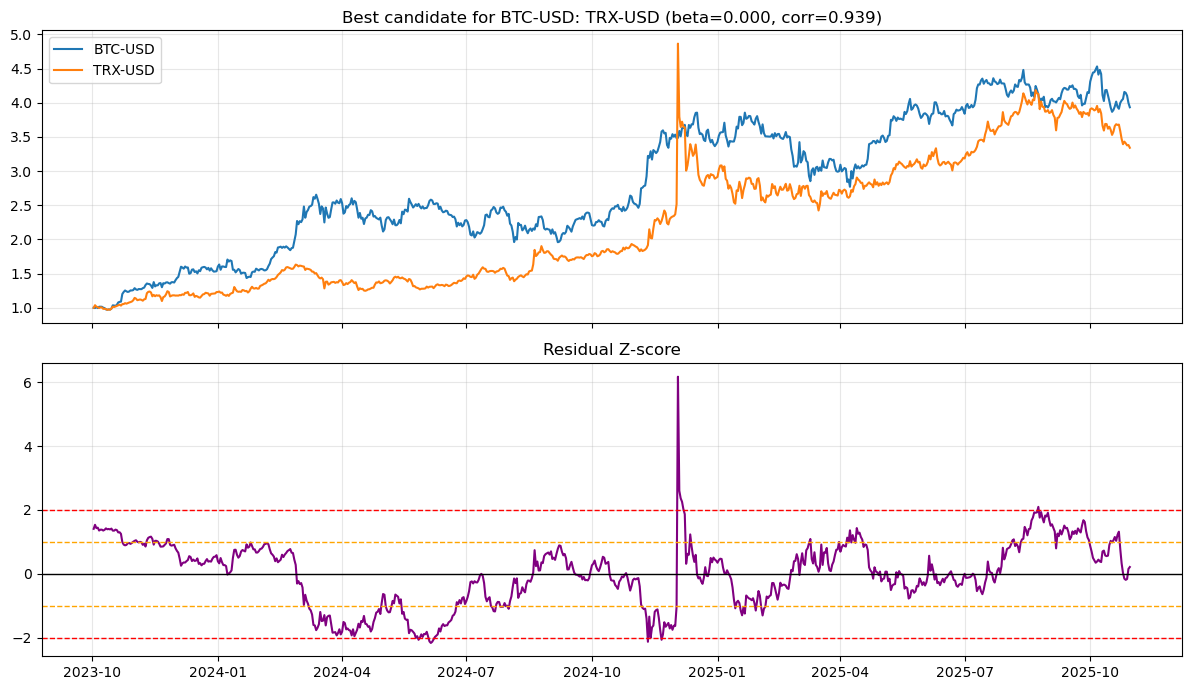

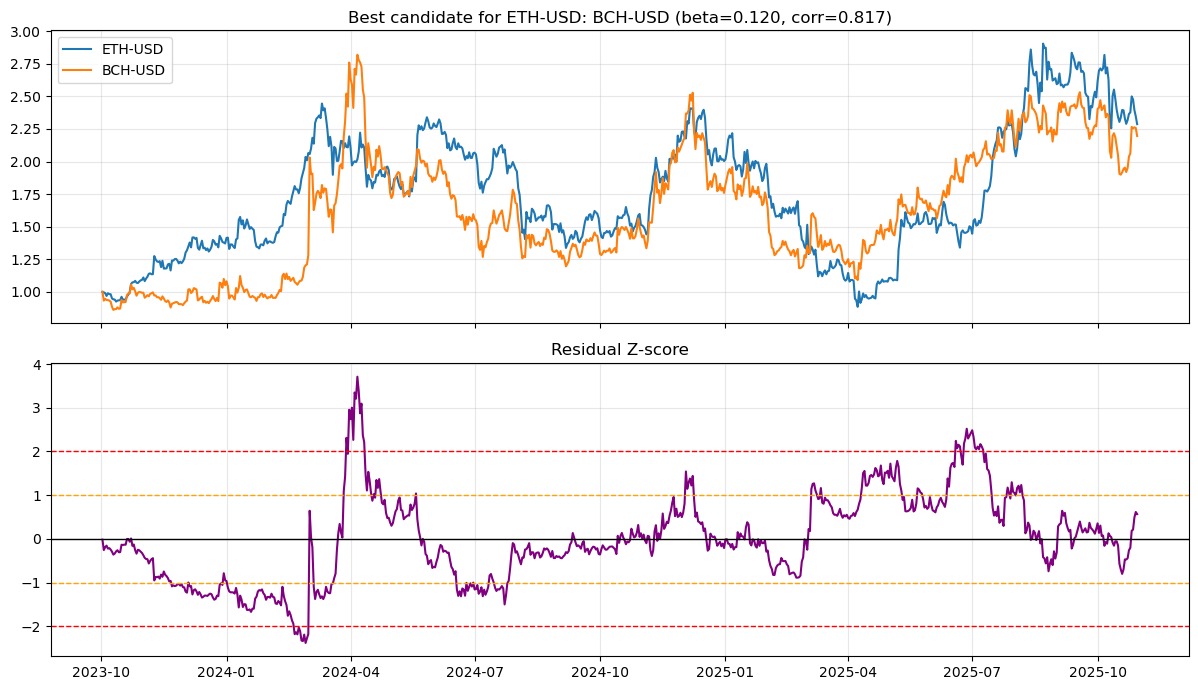

In [146]:
# Visualize best pair per base (normalized prices + residual z-score)
import matplotlib.pyplot as plt
for b in bases:
    try:
        best_row = combo_sorted[combo_sorted['base'] == b].iloc[0]
        c = best_row['ticker']
        x = prices_union[b].dropna()
        y = prices_union[c].dropna()
        df_pair = pd.concat([x.rename(b), y.rename(c)], axis=1).dropna()
        X = sm.add_constant(df_pair[b])
        model = sm.OLS(df_pair[c], X).fit()
        resid = model.resid
        z = (resid - resid.mean()) / resid.std(ddof=0)
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
        # Normalized prices
        ax1.plot(df_pair.index, df_pair[b] / df_pair[b].iloc[0], label=b)
        ax1.plot(df_pair.index, df_pair[c] / df_pair[c].iloc[0], label=c)
        ax1.set_title(f"Best candidate for {b}: {c} (beta={model.params[b]:.3f}, corr={df_pair[b].corr(df_pair[c]):.3f})")
        ax1.legend(loc='upper left')
        ax1.grid(alpha=0.3)
        # Z-score
        ax2.plot(z.index, z, color='purple')
        ax2.axhline(0, color='k', lw=1)
        for th, col in [(1.0,'orange'), (2.0,'red'), (-1.0,'orange'), (-2.0,'red')]:
            ax2.axhline(th, color=col, ls='--', lw=1)
        ax2.set_title("Residual Z-score")
        ax2.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Viz WARN] {b}: {e}")

In [147]:
# === Signal generation for best selected pair ===
import math
from datetime import datetime

assert 'combo_sorted' in globals() and not combo_sorted.empty, "Run the batch scan cell first."

# Use persisted selection if available
if 'SELECTED_BASE' in globals() and 'SELECTED_CAND' in globals():
    BASE, CAND = SELECTED_BASE, SELECTED_CAND
else:
    row = combo_sorted.iloc[0]
    BASE = row['base']
    CAND = row['ticker']

# Recompute latest z and beta for robustness
x = prices_union[BASE].dropna()
y = prices_union[CAND].dropna()
df_pair = pd.concat([x.rename(BASE), y.rename(CAND)], axis=1).dropna()
X = sm.add_constant(df_pair[BASE])
mdl = sm.OLS(df_pair[CAND], X).fit()
resid = mdl.resid
z = (resid - resid.mean()) / resid.std(ddof=0)

beta = float(mdl.params[BASE])
z_now = float(z.iloc[-1])

# Get half-life from combo_sorted for this pair if available
try:
    hl_days = float(combo_sorted[(combo_sorted['base']==BASE) & (combo_sorted['ticker']==CAND)].iloc[0].get('half_life', np.nan))
except Exception:
    hl_days = np.nan

# Direction
if z_now >= Z_ENTER:
    direction = f"Short {CAND} / Long {BASE}"
elif z_now <= -Z_ENTER:
    direction = f"Long {CAND} / Short {BASE}"
else:
    direction = "No trade (|z| below entry)"

# Time stop in days
time_stop_days = math.ceil((hl_days if np.isfinite(hl_days) else 60.0) * TIME_STOP_FACTOR)

print("=== Signal (", datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC'), ") ===")
print(f"Base: {BASE} | Candidate: {CAND} | beta={beta:.3f} | z_now={z_now:.2f} | half_life≈{hl_days:.1f}d")
print(f"Entry rule: enter when |z| >= {Z_ENTER}")
print(f"Exit rule: exit when |z| <= {Z_EXIT}")
print(f"Hard stop: |z| >= {Z_STOP}")
print(f"Time stop: {time_stop_days} trading days (≈ {time_stop_days/21:.1f} months)")
print(f"Direction now: {direction}")
print("Sizing (market-neutral):")
print("  Notional example: allocate $1.00 total abs exposure.")
print("  Leg sizes proportional to [1, beta] and normalized so |long|+|short|=1.")
print("  For Long CAND / Short BASE: weights ≈ [+1/(1+|beta|), -beta/(1+|beta|)]")
print("  For Short CAND / Long BASE: weights ≈ [-1/(1+|beta|), +beta/(1+|beta|)]")

=== Signal ( 2025-10-31 20:58 UTC ) ===
Base: ETH-USD | Candidate: BCH-USD | beta=0.120 | z_now=0.57 | half_life≈28.7d
Entry rule: enter when |z| >= 2.0
Exit rule: exit when |z| <= 0.5
Hard stop: |z| >= 3.0
Time stop: 29 trading days (≈ 1.4 months)
Direction now: No trade (|z| below entry)
Sizing (market-neutral):
  Notional example: allocate $1.00 total abs exposure.
  Leg sizes proportional to [1, beta] and normalized so |long|+|short|=1.
  For Long CAND / Short BASE: weights ≈ [+1/(1+|beta|), -beta/(1+|beta|)]
  For Short CAND / Long BASE: weights ≈ [-1/(1+|beta|), +beta/(1+|beta|)]


C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\660512079.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("=== Signal (", datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC'), ") ===")


In [148]:
# Override/augment signal with concrete USD sizing (uses compute_notional_from_model)
from datetime import datetime, timedelta, UTC
import math, json

try:
    b = SELECTED_BASE; c = SELECTED_CAND
    px_b = float(prices_union[b].dropna().iloc[-1])
    px_c = float(prices_union[c].dropna().iloc[-1])
    beta_val = float(beta)
    z_val = float(z_now)

    # use global half-life if present
    hl_days_val = float(time_stop_days) if 'time_stop_days' in globals() and time_stop_days else None
    abs_notional = compute_notional_from_model(z_val, hl_days_val)

    # Hedge weights normalized so |w_b| + |w_c| = 1
    denom = 1.0 + abs(beta_val)
    w_c_abs = 1.0 / denom
    w_b_abs = abs(beta_val) / denom

    signal = {
        'as_of_utc': datetime.now(UTC).strftime('%Y-%m-%d %H:%M:%S %Z'),
        'base': b,
        'candidate': c,
        'beta': beta_val,
        'z_now': z_val,
        'z_enter': Z_ENTER,
        'z_exit': Z_EXIT,
        'z_stop': Z_STOP,
        'time_stop_days': int(time_stop_days) if 'time_stop_days' in globals() else None,
        'notional_abs_usd': float(abs_notional),
        'sizing_mode': SIZING_MODE,
    }

    if abs(z_val) >= Z_ENTER:
        direction = 'short_cand_long_base' if z_val > 0 else 'long_cand_short_base'
        sgn_c = -1 if z_val > 0 else 1
        sgn_b = 1 if z_val > 0 else -1
        usd_c = sgn_c * w_c_abs * abs_notional
        usd_b = sgn_b * w_b_abs * abs_notional
        signal.update({
            'status': 'enter',
            'direction': direction,
            'usd': {'cand': round(float(usd_c), 2), 'base': round(float(usd_b), 2)},
            'weights_abs': {'cand': round(float(w_c_abs), 6), 'base': round(float(w_b_abs), 6)},
            'px': {'cand': px_c, 'base': px_b},
        })
        print(f"USD sizing (mode={SIZING_MODE}): {c}: {usd_c:+.2f} | {b}: {usd_b:+.2f}  (|sum|={abs(usd_c)+abs(usd_b):.2f})")
    else:
        # Preview sizing only（方向按 long_cand/short_base 预览）
        usd_c =  w_c_abs * abs_notional
        usd_b = -w_b_abs * abs_notional
        signal.update({
            'status': 'no-trade',
            'direction_preview': 'long_cand_short_base',
            'usd_preview': {'cand': round(float(usd_c), 2), 'base': round(float(usd_b), 2)},
            'weights_abs': {'cand': round(float(w_c_abs), 6), 'base': round(float(w_b_abs), 6)},
            'px': {'cand': px_c, 'base': px_b},
        })
        print(f"Preview USD sizing (mode={SIZING_MODE}): {c}: {usd_c:+.2f} | {b}: {usd_b:+.2f}  (|sum|={abs(usd_c)+abs(usd_b):.2f})")

    # Persist JSON
    out = {'meta': {'source': 'statistic_analysis.ipynb', 'version': 2}, 'signal': signal}
    with open('signal_latest.json', 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=2)
    print('Saved signal_latest.json')
except Exception as e:
    print('Signal sizing override failed:', e)

Preview USD sizing (mode=linear): BCH-USD: +0.23 | ETH-USD: -0.03  (|sum|=0.26)
Saved signal_latest.json


Backtest KPIs for ETH-USD vs BCH-USD
  total_return: 0.9840
  ann_return: 0.2554
  ann_vol: 0.3498
  sharpe: 0.7935
  max_dd: 0.1658
  trades: 7
  avg_holding_days: 9.5714


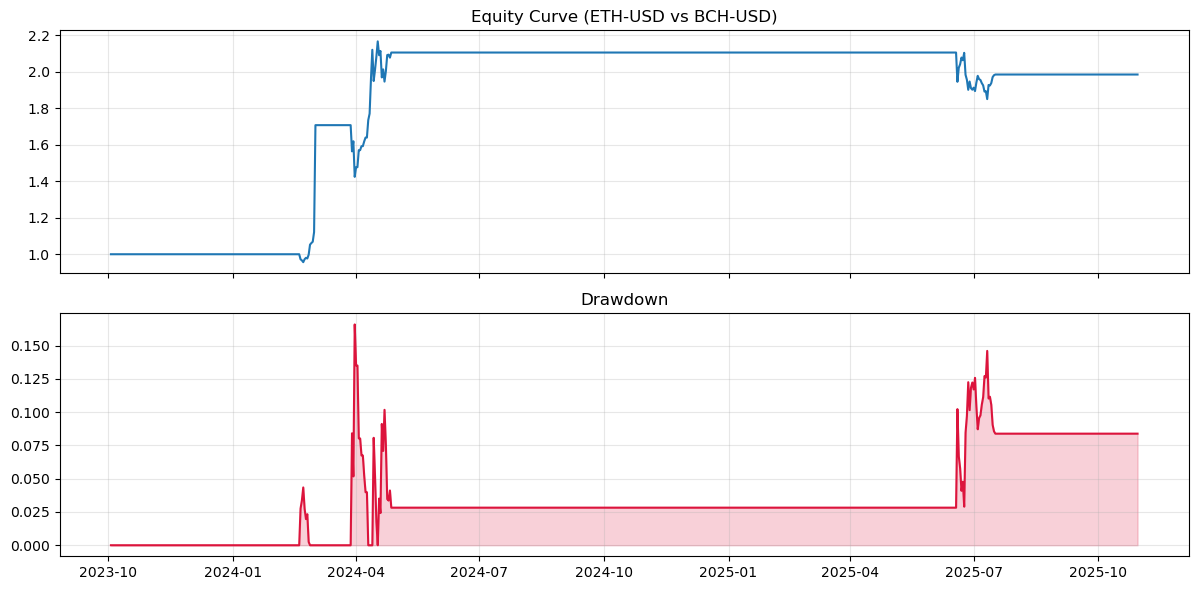

,entry,exit,reason,holding
2,2024-04-03,2024-04-04,hard_stop,1
3,2024-04-05,2024-04-06,hard_stop,1
4,2024-04-07,2024-04-09,hard_stop,2
5,2024-04-10,2024-04-28,revert,18
6,2025-06-19,2025-07-18,time_stop,29


In [149]:
# === Mini backtest for the selected best pair (auto base) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def backtest_pair(prices: pd.DataFrame, base: str, cand: str,
                  z_enter=2.0, z_exit=0.5, z_stop=3.0,
                  time_stop_days=60, use_log=False):
    px_base = prices[base].dropna()
    px_cand = prices[cand].dropna()
    df = pd.concat([px_base.rename(base), px_cand.rename(cand)], axis=1).dropna()
    if use_log:
        df = np.log(df)
    X = sm.add_constant(df[base])
    mdl = sm.OLS(df[cand], X).fit()
    beta = float(mdl.params[base])
    resid = mdl.resid
    z = (resid - resid.mean())/resid.std(ddof=0)

    # Daily returns in price space
    ret = df.pct_change().dropna()
    # If log-space used, convert returns as diff (approx to pct for small moves)
    if use_log:
        ret = df.diff().dropna()

    dates = ret.index
    pos_c = 0.0  # weight on cand
    pos_b = 0.0  # weight on base
    entry_date = None
    pnl = []
    equity = [1.0]
    max_equity = 1.0
    dd = [0.0]
    trades = []

    def target_weights(zv):
        # Normalize so |w_c| + |w_b| = 1 using beta
        if zv >= z_enter:
            wc = -1.0
            wb = +beta
        elif zv <= -z_enter:
            wc = +1.0
            wb = -beta
        else:
            return 0.0, 0.0
        scale = 1.0/(abs(wc)+abs(wb)) if (abs(wc)+abs(wb))>0 else 0.0
        return wc*scale, wb*scale

    holding = 0
    for i, dt in enumerate(dates):
        # compute z today (align index)
        if dt not in z.index:
            pnl.append(0.0)
            equity.append(equity[-1])
            dd.append((max_equity-equity[-1])/max_equity)
            continue
        zt = float(z.loc[dt])

        # Entry/Exit/Stop
        if pos_c == 0.0 and pos_b == 0.0:
            wc, wb = target_weights(zt)
            if wc != 0.0:
                pos_c, pos_b = wc, wb
                entry_date = dt
                holding = 0
        else:
            holding += 1
            # Hard stop
            if abs(zt) >= z_stop:
                trades.append({"entry": entry_date, "exit": dt, "reason":"hard_stop", "holding": holding})
                pos_c = pos_b = 0.0
                holding = 0
            # Time stop
            elif holding >= time_stop_days:
                trades.append({"entry": entry_date, "exit": dt, "reason":"time_stop", "holding": holding})
                pos_c = pos_b = 0.0
                holding = 0
            # Exit on mean reversion
            elif abs(zt) <= z_exit:
                trades.append({"entry": entry_date, "exit": dt, "reason":"revert", "holding": holding})
                pos_c = pos_b = 0.0
                holding = 0

        # PnL update
        rc = ret.iloc[i][cand] if i < len(ret) else 0.0
        rb = ret.iloc[i][base] if i < len(ret) else 0.0
        day_pnl = pos_c*rc + pos_b*rb
        pnl.append(day_pnl)
        eq = equity[-1]*(1.0 + day_pnl)
        equity.append(eq)
        max_equity = max(max_equity, eq)
        dd.append((max_equity-eq)/max_equity)

    equity = pd.Series(equity[1:], index=dates)
    pnl = pd.Series(pnl, index=dates)
    dd = pd.Series(dd[1:], index=dates)

    kpis = {}
    kpis['total_return'] = equity.iloc[-1]-1.0
    kpis['ann_return'] = (equity.iloc[-1])**(252/len(equity)) - 1.0 if len(equity)>0 else 0.0
    kpis['ann_vol'] = pnl.std(ddof=0)*np.sqrt(252)
    kpis['sharpe'] = (pnl.mean()/pnl.std(ddof=0))*np.sqrt(252) if pnl.std(ddof=0)>0 else 0.0
    kpis['max_dd'] = dd.max()
    kpis['trades'] = len(trades)
    kpis['avg_holding_days'] = np.mean([t['holding'] for t in trades]) if trades else 0

    return {
        'beta': beta,
        'equity': equity,
        'pnl': pnl,
        'drawdown': dd,
        'trades': pd.DataFrame(trades),
        'kpis': kpis
    }

# Choose pair
if 'SELECTED_ROW' in globals():
    BASE = str(SELECTED_ROW['base'])
    CAND = str(SELECTED_ROW['ticker'])
    hl = float(SELECTED_ROW.get('half_life', 60.0))
else:
    best = combo_sorted.iloc[0]
    BASE = best['base']
    CAND = best['ticker']
    hl = float(best.get('half_life', 60.0))

res = backtest_pair(prices_union, BASE, CAND,
                    z_enter=Z_ENTER, z_exit=Z_EXIT, z_stop=Z_STOP,
                    time_stop_days=int(np.ceil(hl*TIME_STOP_FACTOR)),
                    use_log=LOG_PRICE)

print("Backtest KPIs for", BASE, "vs", CAND)
for k,v in res['kpis'].items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

# Plot equity and drawdown
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax1.plot(res['equity'].index, res['equity'].values)
ax1.set_title(f"Equity Curve ({BASE} vs {CAND})")
ax1.grid(alpha=0.3)
ax2.plot(res['drawdown'].index, res['drawdown'].values, color='crimson')
ax2.fill_between(res['drawdown'].index, 0, res['drawdown'].values, color='crimson', alpha=0.2)
ax2.set_title("Drawdown")
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Show last 5 trades
if not res['trades'].empty:
    display(res['trades'].tail(5))
else:
    print("No trades in backtest with current thresholds.")

## ⏱️ Automation (optional)

You can schedule this notebook to run automatically via GitHub Actions:

1. Save this repo to GitHub.
2. Add a workflow file at `.github/workflows/eth-pair-scan.yml` with steps to:
   - set up Python
   - `pip install -r requirements.txt`
   - execute the notebook headless (e.g., with papermill)
3. Artifacts: upload the output CSVs and an executed `.ipynb`.

Suggested requirements.txt:
```
papermill
jupyter
pandas
numpy
yfinance
statsmodels
scipy
matplotlib
```

Suggested workflow snippet:
```
name: ETH Pair Scan
on:
  schedule:
    - cron: '0 1 * * *'   # daily 01:00 UTC
  workflow_dispatch: {}
jobs:
  run:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - uses: actions/setup-python@v5
        with:
          python-version: '3.11'
      - run: pip install -r requirements.txt
      - name: Execute notebook
        run: |
          papermill "statistic_analysis.ipynb" "statistic_analysis_out.ipynb"
      - name: Upload artifacts
        uses: actions/upload-artifact@v4
        with:
          name: results
          path: |
            statistic_analysis_out.ipynb
            pair_scan_results_*.csv
```


C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\875002824.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = float(X.params[1])
C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\875002824.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid = df_pair[c] - (float(X.params[0]) + beta * df_pair[b])


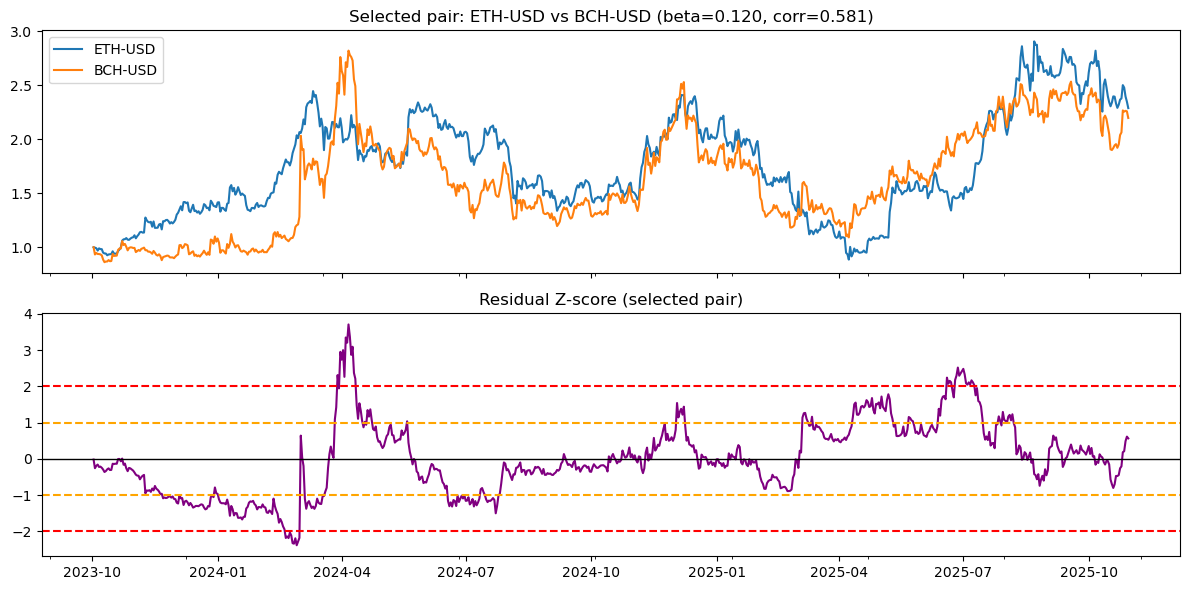

Plotted selected pair only: base=ETH-USD cand=BCH-USD


In [150]:
# === Plot selected pair only (respects selection) ===
try:
	import matplotlib.pyplot as plt
	from statsmodels.regression.linear_model import OLS
	import numpy as np
	
	b = SELECTED_BASE; c = SELECTED_CAND
	assert b in prices_union.columns and c in prices_union.columns
	
	df_pair = prices_union[[b, c]].dropna()
	X = OLS(df_pair[c], np.column_stack([np.ones(len(df_pair)), df_pair[b]])).fit()
	beta = float(X.params[1])
	resid = df_pair[c] - (float(X.params[0]) + beta * df_pair[b])
	z = (resid - resid.mean()) / resid.std(ddof=0)
	
	fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
	(df_pair / df_pair.iloc[0]).plot(ax=ax1)
	ax1.set_title(f"Selected pair: {b} vs {c} (beta={beta:.3f}, corr={df_pair[b].pct_change().corr(df_pair[c].pct_change()):.3f})")
	ax1.legend()
	
	ax2.plot(z.index, z.values, color='purple')
	ax2.axhline(0, color='black', linewidth=1)
	for lev, color in [(1, 'orange'), (2, 'red')] :
		ax2.axhline(+lev, color=color, linestyle='--'); ax2.axhline(-lev, color=color, linestyle='--')
	ax2.set_title('Residual Z-score (selected pair)')
	plt.tight_layout(); plt.show()
	print(f"Plotted selected pair only: base={b} cand={c}")
except Exception as e:
	print('Selected-pair plot failed:', e)

In [151]:
# === Multi-base top selection + USD signal + backtest ===

import numpy as np, pandas as pd, json, math, os
from datetime import datetime, UTC
from statsmodels.regression.linear_model import OLS

# Helpers (reuse from earlier cells if present)
try:
	UNDERLYING_MAP
except NameError:
	UNDERLYING_MAP = {
		'WETH': 'ETH', 'WBTC': 'BTC', 'WSTETH': 'ETH', 'STETH': 'ETH',
		'WTRX': 'TRX', 'WBCH': 'BCH', 'WBNB': 'BNB', 'WBETH': 'ETH',
		'WAVAX': 'AVAX', 'WSOL': 'SOL', 'WADA': 'ADA', 'WXTZ': 'XTZ',
	}
WRAPPER_BASES = set(UNDERLYING_MAP.keys())

def base_token(sym: str) -> str:
	return str(sym).split('-')[0].upper().strip()

def root_token(sym: str) -> str:
	b = base_token(sym)
	return UNDERLYING_MAP.get(b, b)

def apply_metric_filters(d, corr_min, coint_max, adf_max, hl_max):
	return d[(d['corr'] >= corr_min) & (d['coint_p'] <= coint_max) & (d['adf_p'] <= adf_max) & (d['half_life'] <= hl_max)]

# Simple half-life estimator from residuals (Ornstein-Uhlenbeck approx)
from numpy.linalg import lstsq

def estimate_half_life(resid: pd.Series) -> float:
	r = resid.dropna().values
	if len(r) < 3:
		return np.nan
	y = r[1:]
	x = r[:-1]
	A = np.vstack([x, np.ones_like(x)]).T
	phi, c = lstsq(A, y, rcond=None)[0]
	if phi <= -1 or phi >= 1:
		return np.nan
	# daily half-life in observations
	try:
		return float(-np.log(2) / np.log(phi))
	except Exception:
		return np.nan

# Backtest (simple z-based entry/exit/stop/time-stop)

def backtest_pair(prices: pd.DataFrame, Z_ENTER: float, Z_EXIT: float, Z_STOP: float, time_stop_days: int, beta: float, dynamic_mode: str) -> dict:
	pxb = prices.iloc[:, 0].astype(float)
	pxc = prices.iloc[:, 1].astype(float)
	ret_b = pxb.pct_change().fillna(0.0)
	ret_c = pxc.pct_change().fillna(0.0)

	# residual/z
	mdl = OLS(pxc, np.column_stack([np.ones(len(pxb)), pxb])).fit()
	resid = pxc - (float(mdl.params[0]) + float(mdl.params[1]) * pxb)
	z = (resid - resid.mean()) / resid.std(ddof=0)

	pos = 0 # +1: long C short B; -1: short C long B; 0: flat
	enter_idx = None
	equity = [1.0]
	trade_log = []

	denom = 1.0 + abs(beta)
	w_c_abs = 1.0 / denom
	w_b_abs = abs(beta) / denom

	for i in range(1, len(z)):
		zi = z.iloc[i]
		# use same compute_notional_from_model()
		abs_notional = compute_notional_from_model(float(zi), None) if dynamic_mode != 'fixed' else NOTIONAL_BASE_USD

		if pos == 0:
			if abs(zi) >= Z_ENTER:
				pos = 1 if zi < 0 else -1  # z<0 => long C / short B
				enter_idx = i
		else:
			held = i - enter_idx if enter_idx is not None else 0
			# exit rules
			if abs(zi) <= Z_EXIT or abs(zi) >= Z_STOP or (time_stop_days > 0 and held >= time_stop_days):
				trade_log.append({'entry': z.index[enter_idx].date().isoformat(), 'exit': z.index[i].date().isoformat(),
					'reason': 'revert' if abs(zi) <= Z_EXIT else ('hard_stop' if abs(zi) >= Z_STOP else 'time_stop'),
					'holding': int(held)})
				pos = 0
				enter_idx = None

		# PnL update (USD weighted returns; sign per leg)
		usd_c = w_c_abs * abs_notional * (1 if pos > 0 else (-1 if pos < 0 else 0))
		usd_b = w_b_abs * abs_notional * (-1 if pos > 0 else (1 if pos < 0 else 0))
		step_ret = 0.0
		if abs(usd_c) + abs(usd_b) > 0:
			step_ret = (usd_c * ret_c.iloc[i] + usd_b * ret_b.iloc[i]) / max(1e-9, abs(usd_c) + abs(usd_b))
		equity.append(equity[-1] * (1.0 + step_ret))

	eq = pd.Series(equity, index=z.index)
	dd = 1 - eq / eq.cummax()
	ann = (eq.iloc[-1] / eq.iloc[0]) ** (252/len(eq)) - 1 if len(eq) > 2 else np.nan
	vol = eq.pct_change().std(ddof=0) * np.sqrt(252)
	sharpe = (ann / vol) if vol and not np.isnan(vol) and vol != 0 else np.nan

	return {
		'total_return': float(eq.iloc[-1] - 1.0),
		'ann_return': float(ann) if ann is not None else None,
		'ann_vol': float(vol) if vol is not None else None,
		'sharpe': float(sharpe) if sharpe is not None else None,
		'max_dd': float(dd.max()),
		'trades': len(trade_log),
		'avg_holding_days': float(np.mean([t['holding'] for t in trade_log])) if trade_log else 0.0,
		'trades_table': trade_log,
	}

# Provide dfb fallback from combo if needed
if 'dfb' not in globals() or not isinstance(dfb, dict) or not len(dfb):
	if 'combo' in globals() and isinstance(combo, pd.DataFrame) and len(combo):
		dfb = {b: combo[combo['base'] == b].copy() for b in combo['base'].unique()}
		print('Built dfb from combo for bases:', list(dfb.keys()))
	else:
		dfb = {}

bases_to_run = ['BTC-USD', 'ETH-USD']
results = []

for base in bases_to_run:
	# 1) choose best candidate for this base from scan results with filters/dedup
	if base not in dfb or not len(dfb[base]):
		print(f"Scan results for {base} not found; please run the batch scan cell above first.")
		continue
	df = dfb[base].copy()
	if EXCLUDE_WRAPPERS:
		df = df[~df['ticker'].map(lambda s: base_token(s) in WRAPPER_BASES)]
	if 'exclude_stables' in globals():
		df = df[~df['ticker'].map(lambda s: base_token(s) in exclude_stables)]

	if STRICT_FILTERS:
		df_f = apply_metric_filters(df, CORR_MIN, COINT_P_MAX, ADF_P_MAX, HL_MAX_DAYS)
		if not len(df_f):
			df_f = apply_metric_filters(df, max(0.55, CORR_MIN - 0.15), min(0.15, COINT_P_MAX + 0.10), min(0.15, ADF_P_MAX + 0.10), min(240, HL_MAX_DAYS * 2))
			if len(df_f):
				print(f"[{base}] Strict filters yielded 0; using softened thresholds.")
		df = df_f

	if DEDUP_BY_ROOT and len(df):
		df['_root'] = df['ticker'].map(root_token)
		df = df.sort_values('score', ascending=False).drop_duplicates(subset=['_root'], keep='first')
		df = df.drop(columns=['_root'])

	if not len(df):
		print(f"[{base}] No candidates after filters.")
		continue

	best = df.sort_values('score', ascending=False).iloc[0]
	cand = best['ticker']
	pair = [base, cand]

	# 2) get prices and compute beta/z/half-life
	pair_prices = prices_union[pair].dropna()
	mdl = OLS(pair_prices[cand], np.column_stack([np.ones(len(pair_prices)), pair_prices[base]])).fit()
	alpha = float(mdl.params[0]); beta = float(mdl.params[1])
	resid = pair_prices[cand] - (alpha + beta * pair_prices[base])
	z = (resid - resid.mean()) / resid.std(ddof=0)
	z_now = float(z.iloc[-1]) if len(z) else np.nan
	hl = estimate_half_life(resid)
	time_stop_days = int(round(hl * TIME_STOP_FACTOR)) if not math.isnan(hl) and hl is not None else 0

	# 3) Sizing in USD via compute_notional_from_model()
	abs_notional = compute_notional_from_model(z_now, hl)
	denom = 1.0 + abs(beta)
	w_c_abs = 1.0 / denom
	w_b_abs = abs(beta) / denom

	if abs(z_now) >= Z_ENTER:
		direction = 'short_cand_long_base' if z_now > 0 else 'long_cand_short_base'
		sgn_c = -1 if z_now > 0 else 1
		sgn_b = 1 if z_now > 0 else -1
		usd_c = sgn_c * w_c_abs * abs_notional
		usd_b = sgn_b * w_b_abs * abs_notional
		status = 'enter'
	else:
		direction = 'no-trade'
		usd_c = w_c_abs * abs_notional  # 预览：长 C 短 B 方向
		usd_b = -w_b_abs * abs_notional
		status = 'no-trade'

	# 4) Backtest for this pair (uses same mode)
	bt = backtest_pair(pair_prices[[base, cand]], Z_ENTER, Z_EXIT, Z_STOP, time_stop_days, beta, SIZING_MODE)

	sig = {
		'base': base,
		'candidate': cand,
		'beta': float(beta),
		'z_now': float(z_now) if not np.isnan(z_now) else None,
		'half_life_days': float(hl) if hl is not None and not np.isnan(hl) else None,
		'time_stop_days': time_stop_days,
		'notional_abs_usd': round(float(abs_notional), 2),
		'usd': {'cand': round(float(usd_c), 2), 'base': round(float(usd_b), 2)},
		'weights_abs': {'cand': round(float(w_c_abs), 6), 'base': round(float(w_b_abs), 6)},
		'entry_rule': f"|z|>={Z_ENTER}", 'exit_rule': f"|z|<={Z_EXIT}", 'hard_stop': f"|z|>={Z_STOP}",
		'sizing_mode': SIZING_MODE,
		'log_price': bool(LOG_PRICE), 'status': status, 'direction': direction,
	}
	results.append({'signal': sig, 'backtest': bt})
	print(f"[{base}] Selected {cand} | z_now={sig['z_now']:.2f} | notional=${sig['notional_abs_usd']:.2f} | USD legs: C={sig['usd']['cand']} B={sig['usd']['base']} | mode={SIZING_MODE}")
	print(f"   KPIs: ret={bt['total_return']:.3f}, ann={bt['ann_return']:.3f}, vol={bt['ann_vol']:.3f}, sharpe={bt['sharpe']:.3f}, maxDD={bt['max_dd']:.3f}, trades={bt['trades']}")

# Persist combined signals
out = {
	'meta': {'as_of_utc': datetime.now(UTC).strftime('%Y-%m-%d %H:%M:%S %Z'), 'source': 'statistic_analysis.ipynb', 'version': 1},
	'results': results,
}
with open('signals_multi.json', 'w', encoding='utf-8') as f:
	json.dump(out, f, ensure_ascii=False, indent=2)
print('Saved signals_multi.json')

[BTC-USD] Selected TRX-USD | z_now=0.21 | notional=$0.00 | USD legs: C=0.0 B=-0.0 | mode=linear
   KPIs: ret=-0.890, ann=-0.519, vol=0.564, sharpe=-0.921, maxDD=0.934, trades=5
[ETH-USD] Strict filters yielded 0; using softened thresholds.
[ETH-USD] Selected BCH-USD | z_now=0.57 | notional=$0.26 | USD legs: C=0.23 B=-0.03 | mode=linear
   KPIs: ret=0.980, ann=0.254, vol=0.350, sharpe=0.727, maxDD=0.166, trades=7
Saved signals_multi.json


C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\2762198173.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = float(mdl.params[0]); beta = float(mdl.params[1])
C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\2762198173.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid = pxc - (float(mdl.params[0]) + float(mdl.params[1]) * pxb)
C:\Users\Taoye\AppData\Local\Temp\ipykernel_26228\2762198173.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 